<a href="https://colab.research.google.com/github/Manojkdara/Surrogate-Model-for-1D-Nonlinear-Bar-Elasto-Plastic-/blob/main/Surrogate_Model_for_1D_Nonlinear_Bar_(Elasto_Plastic).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [ ]:
length = 1
area = 0.01
stress_y= 300e6
H= 5e9
F= 4e6

class pre_processing:
  def __init__(self,length,area,stress_y) :
    self.l    = length
    self.A    = area
    self.stress_y   =stress_y
    self.E = np.random.uniform(1.5e11, 2.2e11, 2000)
    self.H = np.random.uniform(2.0e9, 1.0e10, 2000)
    self.F = np.random.uniform(5.0e5, 5.0e6, 2000)


  def stress(self):
    stress = self.F /self.A
    return stress

  def elastic_strain(self):
    return self.stress()/self.E

  def yield_strain(self):
    yield_strain=  self.stress_y/self.E
    return yield_strain

  def plastic_strain(self):
    sigma = self.stress()
    plastic_strain= (sigma-self.stress_y)/self.H
    return plastic_strain

  def total_strain(self):
    sigma = self.stress()

    total_strain = np.where(sigma <= self.stress_y,self.elastic_strain(),
            self.yield_strain() + self.plastic_strain())

    return total_strain

  def displacement(self):
    u= self.total_strain()*self.l
    return u

Preparing the dataframe

In [ ]:
pre_processing_call = pre_processing(length,area,stress_y)

sigma               = pre_processing_call.stress()  # array of 2000
plastic_mask        = sigma > pre_processing_call.stress_y
num_plastic         = np.sum(plastic_mask)
num_total           = len(sigma)

print("Plastic samples:", num_plastic)
print("Percentage:", num_plastic/num_total*100)

E         =pre_processing_call.E
H         =pre_processing_call.H
F         =pre_processing_call.F
u         =pre_processing_call.displacement()
df        = pd.DataFrame()
df['E']   =E
df['H']   =H
df['F']   =F
df['u']   =u

Plastic samples: 860
Percentage: 43.0


In [ ]:
maxValues = df.max()
print("Max Values:",maxValues)

minValues = df.min()
print("Min Values:",minValues)



Max Values: E    2.199994e+11
H    9.991369e+09
F    4.994732e+06
u    9.279435e-02
dtype: float64
Min Values: E    1.500016e+11
H    2.000740e+09
F    5.007968e+05
u    2.422141e-04
dtype: float64


Visualization of Plastic and Elastic points

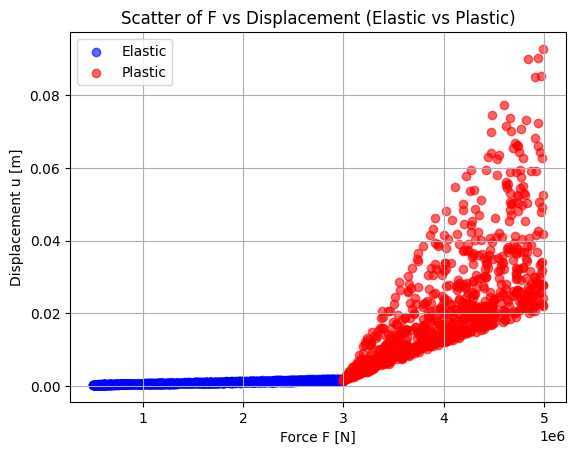

In [ ]:
# Identify elastic and plastic samples
elastic_mask = F/ pre_processing_call.A <= pre_processing_call.stress_y
plastic_mask = ~elastic_mask

plt.scatter(F[elastic_mask], u[elastic_mask], color='blue', alpha=0.6, label='Elastic')   # Elastic points
plt.scatter(F[plastic_mask], u[plastic_mask], color='red', alpha=0.6, label='Plastic')    # Plastic points
plt.xlabel('Force F [N]')
plt.ylabel('Displacement u [m]')
plt.title('Scatter of F vs Displacement (Elastic vs Plastic)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
X = X.astype('float64')
print("NaN before:", np.isnan(X).any())
print("Inf before:", np.isinf(X).any())


NaN before: E    False
H    False
F    False
dtype: bool
Inf before: E    False
H    False
F    False
dtype: bool


Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler     # Scaling

scaler    = MinMaxScaler()
norm_df   = scaler.fit_transform(df)
scaled_df = pd.DataFrame(norm_df, columns=df.columns)
scaled_df.head()

,E,H,F,u
0,0.490903,0.380714,0.285011,0.007824
1,0.961988,0.046398,0.397184,0.008746
2,0.765823,0.517790,0.397761,0.009526
3,0.354220,0.633067,0.082891,0.002781
4,0.559912,0.333360,0.922121,0.395501


In [ ]:
maxValues = scaled_df.max()
print("Max Values:",maxValues)

minValues = scaled_df.min()
print("Min Values:",minValues)

Max Values: E    1.0
H    1.0
F    1.0
u    1.0
dtype: float64
Min Values: E    0.0
H    0.0
F    0.0
u    0.0
dtype: float64


In [ ]:
from sklearn.model_selection import train_test_split

X = df.iloc[:, 0:-1].astype('float64')
y = df.iloc[:,-1].astype('float64')

X_train, X_test,y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU,PReLU,ELU
from keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model = Sequential()
model.add(Dense(units=16, activation='relu', input_dim=3))
model.add(Dense(units=16, activation='relu'))
model.add(Dense(units=1, activation='linear'))

callback = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)


model.compile(optimizer='adam',loss='mse',metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_split=0.33,callbacks=callback)

Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
